# Table of Contents

- [Imports](#Imports)
- [Introduction](#Imports)
- [Pipeline Overview](#Pipeline-Overview)
- [Data-Used-&-Data-Preparation](#Data-Used-&-Data-Preparation)
- [Methodology](#Methodology)
- [Results](#Results)

#### Imports

In [12]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import ttest_ind
import matplotlib

In [2]:
# Reading in the datasets
print("Reading UFO data...")
ufo = pd.read_csv('../data/ufos.csv')
print("Reading OkCupid data...")
ok = pd.read_csv('../data/okcupid_profiles.csv')
print("Reading TikTok data...")
tt = pd.read_json('../data/tiktoks.jsonlines', lines=True)
print("Reading Chipotle data...")
chip = pd.read_csv('../data/chipotle.csv')
print("Reading California data...")
cali = pd.read_csv('../data/cali.csv', sep=';')


Reading UFO data...
Reading OkCupid data...
Reading TikTok data...
Reading Chipotle data...
Reading California data...


# Introduction

There are three kinds of lies: lies, damned lies, and statistics. This article looks to explore that third kind though examples. It is increadibly easy to draw subjective conclusions from objective data that it often happens without the author's intention. This is so common that the Wikipedia article for [Misuse of Statistics](https://en.wikipedia.org/wiki/Misuse_of_statistics) starts out by saying "For other uses, see [Manipulation](https://en.wikipedia.org/wiki/Manipulation)."

The issue with statistics is that any form of summary is making subjective choices about what is important about the original dataset, and what can be excluded.

This article will go through some common and some esoteric-but-interesting issues that crop up when making summaries and visuals of data. It should be useful for the layperson who wants to be less easily fooled, as well as for the visualisation creator who wishes to avoid common pitfalls.

It is found that there are many different ways to fool the reader, but these can be divided into visual and numeric categories. First some common visual tricks are explained, and then some numerical phenomena which appear to be paradoxes are covered.


# Pipeline Overview

Five datasets were either downloaded from online sources and stored locally or were genenerated on demand. These datasets were pre-processed to remove problematic or erroneous entries (such as using backticks \` instead of single quotes ').

One of the datasets comes from scraping the social media website TikTok and uses a web-scraper implemented in Python to collect information from TikTok videos.


# Data Used & Data Preparation

> High-level description of the data that was collected. Description of how the data wrangling processes: how was the data selected, cleaned, and merged?

One generated dataset and five real-world datasets were used:

- The [`ok`](https://www.kaggle.com/datasets/andrewmvd/okcupid-profiles) 
    dataset contains OkCupid anonymised dating profiles from 60 000 people
    in the San Francisco, California area. Each profile contains self-reported
    information on the person's gender, ethnicity, body type, height,
    income, sexual orientation, relationship status, and free-form answers 
    to several short-essay questions such as "Things I'm really good at" 
    or "You should message me if...".

- The [`cali`](https://www.kaggle.com/datasets/wduckett/californiaddsexpenditures)
    dataset contains 800 observations of data regarding the 
    allocation of funding from the Department of Developmental Services to
    developmentally-disabled individuals in California in 2014. Each observation
    records the amount of funding allocated, as well as the ethnicity, the 
    sex, and the age of the individual.

- The [`ufo`](https://www.kaggle.com/datasets/camnugent/ufo-sightings-around-the-world)
    dataset contains 70 000 UFO sightings from across the world between
    1906 and 2014. Most of the sightings are in North America, and they all record different
    information about the encounter such as the shape of the UFO, the length of the encounter,
    a free-form description, the date the encounter was documented, and the latitude/longidute
    of the encounter.
    
- The [`chip`](https://www.kaggle.com/datasets/jeffreybraun/chipotle-locations) 
    dataset contains the latitude and longitude of every Chipotle chain restaurant in
    North America.


- The `tt` dataset (collected by the author) contains information about 50 000 
    TikToks scraped between 2022-07-28 and 
    2022-11-03. For each TikTok, the URL, the audio used and the creator name is 
    recorded as well as the number of likes, comments, followers, and follower likes.


- The `book` dataset (which will be generated when it is discussed) contains a set of 1000 imaginary
    books, each rated on their popularity (what fraction of the general population know about the book)
    and the "bingeability" (how easy it is to finish the book).

## Clean up the UFO sightings dataset

The `ufo` dataset had lots of backticks that were replaced with `'`, and some times were 24:00 which were replaced with 23:59. Many of the latitude and longitude values just contained stray characters, such as `-40d203` which were delt with on a case-by-case basis. Additionally only the observations in North America were included so as to ease intepretation of the coordinate data.

In [3]:
# Only include sightings from the US
lat_mean = 40
lng_mean = -100
ufo = ufo[
    (ufo.latitude.between( lat_mean-30, lat_mean+30)) & 
    (ufo.longitude.between(lng_mean-30, lng_mean+30))
]

## Clean up the California dataset

The `cali` dataset was largely well-formatted, however the `Age Cohort` feature was changed so as to make the formatting of the age cohorts more uniform. For example, the cohort `0 to 5` became `00-05`. Additionally, only the `Hispanic` and `White not Hispanic` ethnicities were kept, as the other ethnicities will not be used for explanatory purposes 


In [4]:
# This data set contains data regarding the allocation of funding from the Department of Developmental 
# Services to developmentally-disabled individuals in California in 2014. 
cali['Age Cohort'] = cali['Age Cohort'].replace({
    '0 to 5': '00-05',
    '6 to 12': '06-12',
    '13 to 17': '13-17',
    '18 to 21': '18-21',
    '22 to 50': '22-50',
    '51': '51+',
})
cali = cali[cali.Ethnicity.isin(['White not Hispanic', 'Hispanic'])]

## Clean up the OkCupid Dating dataset

The `ok` dataset required the most pre-processing. The many `essay0`, `essay1`, ..., `essay9` columns were renamed to be more intuitive. The `income` column had many `-1` values which were assumed to represent missing values and so replaced with `np.nan`. The `sex` column only contained `m` or `f` values, and so was supplemented with a new `is_male` column that is true if `sex` is `m`.


In [5]:
ok = ok.rename({
    "essay0": "sa_summary",               # My self summary
    "essay1": "sa_wyd",                   # What I’m doing with my life
    "essay2": "sa_good_at",               # I’m really good at
    "essay3": "sa_most_noticable_thing",  # The first thing people usually notice about me
    "essay4": "sa_favorites",             # Favorite books, movies, show, music, and food
    "essay5": "sa_six_things_i_need",     # The six things I could never do without
    "essay6": "sa_i_think_about",         # I spend a lot of time thinking about
    "essay7": "sa_friday_night",          # On a typical Friday night I am
    "essay8": "sa_something_private",     # The most private thing I am willing to admit
    "essay9": "sa_msg_iff",               # You should message me if...
}, axis='columns')
ok['income'] = ok['income'].replace(-1, np.nan)
ok['is_male'] = np.where(ok['sex'] == 'm', True, False)

The `ok` dataset also has an `ethnicity` column which is a list of ethnicities like `asian, black, other` or `white, other`. These were separated into a new column for each ethnicity like `eth_black` or `eth_other`, where the column is True if that person declared themselves to be of that ethnicity, and False otherwise

In [6]:
tqdm.pandas(desc='Finding Unique Ethnicities')
unique = ok['ethnicity'].progress_apply(
    lambda x: pd.Series(np.nan if pd.isna(x) else [xi.strip() for xi in x.split(',')])
).unstack().unique()
unique = unique[~pd.isna(unique)]

tqdm.pandas(desc='Assigning Ethnicities')
eths = ok['ethnicity'].progress_apply(lambda x: pd.Series(
    np.in1d(unique, [xi.strip() for xi in str(x).split(',')]), 
    index=[(f'eth_{u.replace("/ ", "").replace(" ", "_")}') for u in unique]
))
ok = pd.concat((
    ok, eths
), axis=1)

Finding Unique Ethnicities:   0%|                                                                                                                  | 0/59946 [00:00<?, ?it/s]

AttributeError: 'Series' object has no attribute '_is_builtin_func'

The `ok` dataset also contained the self-declared astrological sign of the participant. However, the column `sign` includes the self-declared importance of the sign to the participant. For example: `pisces but it doesn't matter`, `cancer and it's fun to think about`, or `gemini and it matters a lot`. These qualifications were all removed, and a new sign feature was introduced for each astrological sign that is True only for the user's corresponding sign. For example, a user who stated their sign `gemini and it matters a lot` would be true in the `sign_gemini` column and false in all other `sign_*` columns.

In [7]:
uniq_signs = ok['sign'].apply(
    lambda x: 
    x if pd.isna(x) else (
        x.replace(' and it&rsquo;s fun to think about', '')
        .replace(' but it doesn&rsquo;t matter', '')
        .replace(' and it matters a lot', '')
    )
).unique()
uniq_signs = uniq_signs[~pd.isna(uniq_signs)]

tqdm.pandas(desc='Assigning Astrological Signs')
signs = ok['sign'].progress_apply(lambda x: pd.Series(
    np.in1d(uniq_signs, [xi.strip() for xi in str(x).split(',')]), 
    index=[(f'sign_{u}') for u in uniq_signs]
))
ok = pd.concat((
    ok, signs
), axis=1)



Assigning Astrological Signs:   0%|                                                                                                                | 0/59946 [00:00<?, ?it/s]

AttributeError: 'Series' object has no attribute '_is_builtin_func'

# Methodology

Various plotting and statistical methods were employed. Pairwise independant t-tests were used to explain the problem of multiple comparisons. The effect of different colour scales as well as different colour maps were investigated and recommendations given. Different methods of plotting and summarising two-dimensional distributions were analysed and the constraints of each method enumerated. Three common statistical problems were explained visually, and methods for recognising them presented.

# Results

This section first goes through the problems with exponential data and numerical scales in [Numerical Scales and Exponential Data](#Numerical-Scales-and-Exponential-Data). Then colour is addressed, first in terms of how to use semantic colour scales ([Colour Scales](#Colour-Scales)) and then how to use appropriate colour maps for the application ([Colour Maps](#Colour-Maps)).

Different methods of visualising two dimensional data are covered in [Using the wrong visualisation](#Using-the-wrong-visualisation).

Statistical paradoxes are covered, specifically [The problem of multiple comparisons](#The-problem-of-multiple-comparisons), [Simpson's paradox](#Simpson's-paradox), and finally [Berkson's Paradox](#Berkson's-Paradox).



## Numerical Scales and Exponential Data

Misleading things can happen when you assume your data is roughly clustered around some central value when it is not.

Exponential data is surprisingly common, but knowledge of how to treat that data is less so. As an example, let's look at some data about the number of likes and comments on different TikToks:

Finding Unique Ethnicities:   0%|                                                                                                                  | 0/59946 [00:42<?, ?it/s]


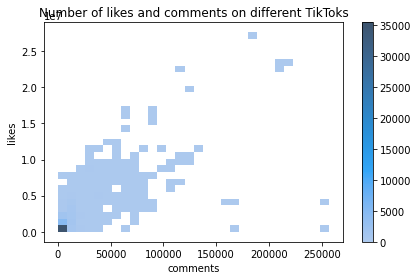

In [8]:
# Plot of comments and likes for TikToks
data = tt[(tt.comments > 0) & (tt.likes > 0)]
sns.histplot(
    data=data[['comments', 'likes']],
    x='comments',
    y='likes',
    bins=(30, 30),
    cbar=True,
)
plt.title('Number of likes and comments on different TikToks')
plt.tight_layout()
plt.show()

We can see that there's loads of datapoints with nearly-zero comments and nearly-zero likes.

One strategy might be to decide a cut-off point, so we'd only look at TikToks with fewer than 1 million (0.1e7) likes and 10 000 comments so that we can "zoom in" on where most of the TikToks seem to be:

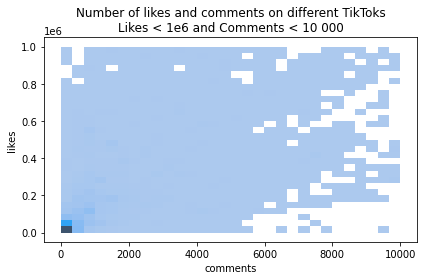

In [9]:
# Plot of comments and likes for TikToks with fewer than 10k comments and fewer than 1M likes
data = tt[(tt.comments > 0) & (tt.likes > 0) & (tt.comments < 10_000) & (tt.likes < 0.1e7)]
sns.histplot(
    data=data[['comments', 'likes']],
    x='comments',
    y='likes',
    bins=(30, 30)
)
plt.title('Number of likes and comments on different TikToks\nLikes < 1e6 and Comments < 10 000')
plt.tight_layout()
plt.show()

But we've got the same problem! There's loads of TikToks with near-zero likes and near-zero comments, so we can't really tell what's going on with the distribution. This is because (to phrase it a bit loosely) exponential distributions look the same at any zoom level. Formally this is called [the memorylessness property](https://en.wikipedia.org/wiki/Exponential_distribution#Memorylessness) of the exponential distribution.

The proper solution would be to transform the data before we plot it, but here's a widget that let's you choose the zoom level so you can see I'm not lying to you:

In [10]:
# Interactive plot where the user can choose the maximum quantile of the data
@interact(quant=widgets.FloatSlider(
    value=1.0,
    min=0.001,
    max=1.0,
    step=0.025,
    description='Upper percentile:',
))
def plt_tiktoks(quant):
    comment_max = int(np.round(tt.comments.quantile(quant)))
    likes_max = int(np.round(tt.likes.quantile(quant)))
    # Plot of comments and likes for TikToks with fewer than 10k comments and fewer than 1M likes
    data = tt[
        (tt.comments > 0) & (tt.likes > 0) & 
        (tt.comments < comment_max) & (tt.likes < likes_max)
    ]
    sns.histplot(
        data=data[['comments', 'likes']],
        x='comments',
        y='likes',
        bins=(30, 30)
    )
    plt.title(f'Number of likes and comments on different TikToks\nLikes < {likes_max} and Comments < {comment_max}')
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='Upper percentile:', max=1.0, min=0.001, step=0.025),…

Play around with the slider to choose the maximum percentile of the data. For example, setting the slider to 0.5 will only plot TikToks where the number of likes is below the median number of likes and the number of comments is also below the median number of comments.

You'll find that the heatmap looks roughly the same regardless of where you put the slider, right up until the slider goes below 0.1. At this point you can see that there are loads of TikToks with about 8000 likes and 35 comments, but this analysis doesn't really mean anything since you had to discarded 90% of your data in order to see this 'pattern'.

Now lets see the true solution: the log-scale. If we plot the logarithm of comments against the logarithm of likes, we can see a the pattern in the data:

In [ ]:
# Plot logarithmic vs linear scales
_fig, axs = plt.subplots(1, 2, figsize=(8, 4))

data = tt[(tt.comments > 0) & (tt.likes > 0)]
sns.histplot(
    data=data[['comments', 'likes']],
    x='comments',
    y='likes',
    bins=(50, 50),
    ax=axs[0],
)
axs[0].set_title(f'X linear, Y linear')
axs[0].set_ylabel(f'Likes (linear)')
axs[0].set_xlabel(f'Comments (linear)')

sns.histplot(
    data=data[['comments', 'likes']],
    x='comments',
    y='likes',
    bins=(50, 50),
    log_scale=(True, True),
    ax=axs[1],
)
axs[1].set_title(f'X logged, Y logged')
axs[1].set_ylabel(f'Likes (logged)')
axs[1].set_xlabel(f'Comments (logged)')

plt.suptitle('Linear vs Logarithmic scales')
plt.tight_layout()

Clearly there's a relationship between comments and likes. We can see that TikToks with more likes generally get more comments, although its important to note that because we're using a log-log scale, it is more accurate to say that TikToks with 10 times more likes generally have 10 times more comments.

We can also see that most TikToks seem to have between $10^4$ and $10^7$ likes, and between $10^2$ and $10^4$ comments. This is impossible to tell from the linear graph.

## Colour Scales

A trickier to spot scaling problem would be with _colour_ scales. For an example, lets look at a dataset of online dating profiles from the mobile app OkCupid. Specifically, let's look at  the correlations between age, height, income, sex, and self-declared ethnicity:

In [ ]:
columns = [
    'age', 'height', 'income', 'is_male', 'eth_asian', 'eth_white',
    'eth_hispanic_latin', 'eth_pacific_islander', 'eth_black',
    'eth_middle_eastern', 'eth_native_american', 'eth_indian',
    'eth_other',
]
formatted_columns = [c.replace('eth', '').replace('_', ' ').title() for c in columns]
sns.heatmap(
    ok[columns].corr(),
    xticklabels=formatted_columns,
    yticklabels=formatted_columns,
)
plt.title('(Incorrect) Heatmap of Correlations')
plt.show()

By definition, correlations are values between -1 and 1, but the default colour scale of this heatmap is from about -0.4 to 1.0 because the smallest correlation value is -0.4. This is problematic because makes the negative correlation between `white` and `asian` seem as negative as the correlation between `is_male` and `height` is positive.


The naïve solution would be to explicitly specify the minimum and maximum values of the heatmap using Seaborn's `vmin` and `vmax` parameters:

In [ ]:
sns.heatmap(
    ok[columns].corr(),
    xticklabels=formatted_columns,
    yticklabels=formatted_columns,
    vmin=-1,                # <--- Let's explicitly set the min
    vmax=1                  # <--- and max values
)
plt.title('(Better) Heatmap of Correlations')
plt.show()

Now we've fixed our scales, so the correlation between `white` and `asian` no longer seems as negative as the correlation between `is_male` and `height` is positive. But this still isn't great, because it's important to know if a correlation is positive or negative. We've fixed the _range_ of the plot, but the colours don't have semantic value. Put another way:

- Does the colour scale cover the entire range of the data? ✅
- Do the colours in the colour scale map to meaningful values? ❌

Seaborn makes fixing the second point really easy with the `center` parameter. Specifying `center=0` will cause Seaborn to use a _diverging_ colourmap, which is specifically designed to represent data which have some notion of a "positive" and "negative". As an added bonus, since we're specifying the center of the data we no longer need to specify the minimum and maximum values, so we can omit `vmin` and `vmax`:

In [ ]:
sns.heatmap(
    ok[columns].corr(),
    xticklabels=formatted_columns,
    yticklabels=formatted_columns,
    center=0,
#     vmin=-1,    # No longer needed because of center=0
#     vmax=1      # No longer needed because of center=0
)
plt.title('(Best) Heatmap of Correlations')
plt.show()

And now it is very obvious that the correlation between `white` and `asian` is negative while the correlation between `is_male` and `height` is positive. Also the negative correlations between identifying as `white` and identifying as `hispanic/latin`, `pacific islander`, `black`, `indian`, and `other` are more obvious.

## Colour Maps

The choice of colour map is also important. Most plotting libraries provide some sort of 'rainbow' colour map. Matplotlib has `gist_rainbow`:

In [11]:
matplotlib.colormaps['gist_rainbow']

AttributeError: module 'matplotlib' has no attribute 'colormaps'

And at first glance `gist_rainbow` doesn't seem too bad, since the point of a colour map is to distinguish between different values, so surely the colour map with a large number of colours in it should be the best? And `gist_rainbow` seems to have a lot of different colours.

The idea that you want lots of colours is (mostly) good, but `gist_rainbow` fails because it is not _perceptually uniform_. This will be easiest to explain by comparing two rainbow-ish colourmaps: `gist_rainbow` and `turbo`:

In [13]:
display(matplotlib.colormaps['gist_rainbow'])
display(matplotlib.colormaps['turbo'])

AttributeError: module 'matplotlib' has no attribute 'colormaps'

Look carefully at the light blue regions of `gist_rainbow` and `turbo`. On `gist_rainbow`, you can kind of see a vertical band of light blue, which quickly goes either to green or dark blue. But on `turbo`, there iesn't really a single band of light blue. It smoothly transitions from a dark blue to a light blue to a green. `turbo` is perceptually uniform because it the perceptual difference between two adjacent colours is uniform.

This is a bit easier to see if we look at discrete chunks of the colour maps side-by-side. Below is a widget that shows just a small portion of the two colour maps. You can move higher and lower in the colour space by moving the `Start` slider:

In [ ]:
# Interactive comparison between the `gist_rainbow` colour map and the `turbo` colour map
@interact(start=widgets.FloatSlider(
    value=0.25,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Start:',
))
def plt_cmaps(start):
    _fig, axs = plt.subplots(2, 1, figsize=(8, 3))

    cmaps = ['gist_rainbow', 'turbo']

    for ax, cmap in zip(axs, cmaps):
        vals = np.round(np.clip(np.linspace(0.0, 0.3, 12) + start, 0.0, 1.0), 2)
        
        ax.imshow([vals], cmap=cmap, vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'{cmap}')
        for i, val in enumerate(vals):

            ax.text(
                i/len(vals)+0.04, 0.5, f'{val}',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes,
            )
    plt.tight_layout()

The importand thing to note here is how `gist_rainbow` has large regions where neighbouring blocks of colour are basically identical. Move the `Start` slider to 0.25 and try to tell the difference between the `gist_rainbow` blocks labelled 0.36, 0.39, 0.41, and 0.44. They're basically identical, but the same blocks in the `turbo` colour map are easily distinguished.

What's more, *any* combination of blocks under the `turbo` colour map is easy to distinguish as any other combination of blocks. That's what makes `turbo` perceptually uniform.

Here's a plot showing of some of the colour maps in matplotlib using a heatmap of UFO sightings in North America as the dataset. Note how easily `turbo` makes it to see areas with fewer UFOs or areas with more UFOs compared to `gist_rainbow`. `viridis` and `inferno` also do fairly well, since they both map large values to bright yellows which make them stand out against the low values which get mapped to darker blacks or purples.

In [ ]:
# 6 heatmaps of UFO sightings in North America
_fig, axs = plt.subplots(2, 3, figsize=(3*4, 2*4))
cmaps = ['gist_rainbow', 'cubehelix', 'turbo', 'rainbow', 'inferno', 'viridis']
for cmap, ax in zip(cmaps, axs.flatten()):
    sns.histplot(
        data=ufo,
        y='latitude',
        x='longitude',
        bins=(40,40),
        cmap=cmap,
        cbar=True,
        ax=ax
    )
    ax.axis('off')
    ax.set_title(f'{cmap}')
plt.suptitle('UFO Sightings in North America under different colour maps')
plt.tight_layout()


## Using the wrong visualisation

Sometimes the problem is using the incorrect type of plot for a particular task, or using a type of plot which isn't wrong, but isn't the best either.

Most infamous of these is the pie chart. Despised by designers and loved by business majors with a point to obscure, this type of plot is generally not reccomended as the human eye has a tricky time differentiating between angles.

For example, look at the pie chart below, showing the self-reported body types

In [ ]:
plt.pie(
    ok.body_type.value_counts().sort_values(),
    labels=ok.body_type.value_counts().sort_values().index,
)
plt.title('Self-reported body type of OkCupid dating profiles')
plt.show()

Immediately there's a problem in that you can't see all the labels clearly. The labels `rather not say`, `used up`, `jacked`, and `overweight` are all covering each other. But there's a more serious issue: can you easily judge if there are more `thin` body types or more `curvy` body types? or how many body types were `althetic` vs `fit`?

The human brain just isn't great at telling the difference between angles. And since a pie chart assigns angles to groups, the human brain just isn't great at telling the difference between slices in a pie chart.

Let's compare the pie chart to a bar chart:

In [ ]:
# Comparison of pie charts vs bar charts
_fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].pie(
    ok.body_type.value_counts().sort_values(),
    labels=ok.body_type.value_counts().sort_values().index,
)
axs[0].set_title('Pie Chart')

sns.histplot(
    data=ok.sort_values('body_type'),
    y='body_type',
    hue='body_type',
    palette='tab10',
    hue_order=ok.body_type.value_counts().sort_values().index,
    legend=False,
)
axs[1].set_title('Bar Chart')
plt.suptitle('Self-reported body type of OkCupid dating profiles')

plt.tight_layout()

The bar chart makes it trivial to tell that more people thought they were `fit` than thought they were `athletic`, and to tell that there are more people who report themselves as `thin` vs `curvy`.

Note how similar the slices for `curvy` and for `a little extra` look on the pie chart, but how different they look on the bar chart.

Another example would be the challenge of plotting a set of measurements from two variables. The simplest version of this would be a 2D histogram. For example, let's look at the latitude and longitude of Chipotle restaurants:

In [ ]:
# Comparison of plotting 2D data
_fig, axs = plt.subplots(2, 3, figsize=(9, 6))

sns.scatterplot(
    data=chip,
    y='latitude',
    x='longitude',
    ax=axs[0, 0],
)
sns.scatterplot(
    data=chip,
    y='latitude',
    x='longitude',
    s=1,
    ax=axs[0, 1]
)
sns.scatterplot(
    data=chip,
    y='latitude',
    x='longitude',
    alpha=0.1,
    ax=axs[0, 2]
)
sns.histplot(
    data=chip,
    y='latitude',
    x='longitude',
    bins=(30, 30),
    ax=axs[1, 0]
)
sns.kdeplot(
    data=chip,
    y='latitude',
    x='longitude',
    ax=axs[1, 1]
)
sns.kdeplot(
    data=chip,
    y='latitude',
    x='longitude',
    ax=axs[1, 2],
    fill=True,
    levels=10,
)

axs[0, 0].set_title('(1) Regular Scatterplot')
axs[0, 1].set_title('(2) Scatterplot: Smaller Points')
axs[0, 2].set_title('(3) Scatterplot: Transparent Points ')
axs[1, 0].set_title('(4) Heatmap')
axs[1, 1].set_title('(5) Kernel Density Estimate:\nContours')
axs[1, 2].set_title('(6) Kernel Density Estimate:\nContinuous')

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')
axs[1, 2].axis('off')

plt.suptitle('Different 2D density visualisations\n(Chipotle locations in North America)')
plt.tight_layout()
plt.show()

The regular scatterplot (1) does alright, but because the default point size is quite big, some points end up covering other points. We can solve this by either reducing the point size (2) or by making the points transparent (3). Transparent points tend to under-emphasize outlier observations and struggle when you've got small regions with many more points than other regions. Smaller point sizes have similar issues to transparent points but can give more precise distributions. 

Both smaller point sizes and transparent points fail to scale well if you need to plot 10 million points instead of 10 thousand. Heatmaps (4) and kernel density estimates (5,6) work well for these tasks, with a heatmap (AKA 2D histogram) nicely summarizing the data while still allowing the reader to see important areas. Kernel Density Estimates have a tendency to over-generalise which may or may not be desirable.

However, histograms and KDE plots both have a parameter that changes the scale of the generalisation. For histograms, more bins mean a finer distribution that fails to generalise, and for KDE plot a smaller bin-width adjustment parameter does the same thing.

Play around with the slider below to see the effect that different bin sizes or bin widths have on the histogram and KDE plot. How close can you get the distributions to looking like the North American continent without having loads of white spaces in between the observations?

In [ ]:
# Comparison of KDE and 2D histograms at different scales
@interact(nbins=widgets.IntSlider(
    value=5,
    min=1,
    max=100,
    step=1,
    description='Bins:',
))
def plt_chipotle(nbins):
    nbins = max(1, nbins)
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    sns.histplot(
        data=chip,
        y='latitude',
        x='longitude',
        bins=(nbins, nbins),
        ax=axs[0]
    )
    axs[0].set_title(f'2D Histogram\nnum bins=({nbins},{nbins})')
    
    sns.kdeplot(
        data=chip,
        y='latitude',
        x='longitude',
        fill=True,
        levels=10,
        ax=axs[1],
        bw_adjust=1/nbins*10
    )
    axs[1].set_title(f'2D KDE\nbin-width adjust={np.round(1/nbins*10, 2)}')
    axs[0].axis('off')
    axs[1].axis('off')
    plt.suptitle('Chipotle locations in the US')
    plt.tight_layout()
    plt.show()

## Statistical Paradoxes

Now we move on from visual problems and onto the damnest of lies: statistics.

### The problem of multiple comparisons

Lets say you group people by their diet: vegetarians and "no preference", and you want to see which group is taller. You'd do a t-test for the difference between their means, with $H_0$ being that the means are equal and $H_1$ being that the means are not equal. Let's use a significance threshold of 0.05:

In [ ]:
# Get all diets
diets = ok.diet.unique()
# And remove the nan diets
diets = diets[~pd.isna(diets)]
# Set the significance threshold
sig_thresh = 0.04

# Then do a t-test for the difference between the means
s1 = ok.loc[ok.diet == 'vegetarian', 'age']
s2 = ok.loc[ok.diet == 'anything', 'age']
p_value = ttest_ind(s1, s2)[1]

equal = p_value <= sig_thresh
print(f"Vegetarians *are{'*' if equal else ' not*'} the same age as people who eat anything (p={np.round(p_value, 4)})")

But what if you didn't just care about vegetarians against the anything-eaters? If you wanted to see if *any* diet was younger or older than *any* other diet, then you might naïvely think you could just do every comparison and see if any comparison was significant:

In [ ]:
# multiple comparisons
diets = ok.diet.unique()
diets = diets[~pd.isna(diets)]

p_values = np.zeros((len(diets), len(diets)))

for i, d1 in enumerate(diets):
    for j, d2 in enumerate(diets):
        s1 = ok.loc[ok.diet == d1, 'age']
        s2 = ok.loc[ok.diet == d2, 'age']
        p_values[i, j] = ttest_ind(s1, s2)[1]
        
sns.heatmap(
    p_values,
    xticklabels=diets,
    yticklabels=diets,
)
plt.show()

However this thinking is flawed. As we do more and more tests, it becomes increasingly likely that some of those tests will be deemed "significant". As an illustrative example, consider rolling two regular 6-sided dice:

We know that the rolls of the two dice are completely unrelated to each other.
But even so, by complete random chance we'd expect both dice to roll the same number $\frac{6}{36}=\frac{1}{6}=16\%$ of the time.

Now if we roll these two dice many many more times, we'd expect the number of times they roll the same number to increase, even though they're rolling *completely at random* . For example if we roll both dice 20 times, the probability of the two dice rolling a different number every single one of the 20 times is $(1-\frac{1}{6})^{20}=2.5\%$.


This is the same thing as performing multiple comparisons. If we do one comparison, then that's the same as doing one roll of both dice. But if we keep on rolling the dice, and keep on doing more comparisons, then eventually the dice will come out the same and eventually we'll find something that's "statistically significant" *by complete random chance*.

If you keep on testing, you'll eventually find something "significant".

Maybe xkcd said it best:

![](https://imgs.xkcd.com/comics/significant.png)


So if you want to compare multiple groups, you best take a look at dedicated statistical test for multiple comparisons:

- [Wikipedia](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)
- [SciPy Docs](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html)

## Simpson's paradox

Simpson's paradox is dreadfully difficult to spot if you aren't looking for it. It comes about when you are trying to compare the averages of two groups, and when you do so it looks like the average of group A are less than the average of group B. However, when you look a bit deeper you see that there's actually some *latent variable* at play, and group A has a different distribution of this latent variable, which causes group A to have a lower average than group B.

Let's look at an example: The California Department of Developmental Services expenditures to help developmentally-disabled individuals in 2014. This dataset has one variable that we're interested in: `Expenditures` which describes how much money someone received. The age, ethnicity, and gender of the recipient of each grant is also recorded.

If we plot the expenditure against the ethnicity of the recipient, it seems like `Hispanic` people are receiving far less on average than `White not Hispanic` people:

In [ ]:
sns.boxenplot(
    data=cali.sort_values('Age Cohort'),
    x='Expenditures',
    y='Ethnicity',
)

plt.title('Expenditure by Ethnicity')

And if we split the data by `Age Cohort`, we see another trend: Older people receive more disability grant money:

In [ ]:
sns.boxenplot(
    data=cali.sort_values('Age Cohort'),
    x='Expenditures',
    y='Age Cohort',
)

This is to be expected, as the elderly are more likely to need disability grant money.

So if we now split the population by both Ethnicity and by Age, we will see that each age bracket of `Hispanic` people do not receive significantly less than each age bracket of `White not Hispanic` people:

In [ ]:
_fig, axs = plt.subplots(2, 1, figsize=(10, 7))
sns.boxenplot(
    data=cali.sort_values('Age Cohort'),
    x='Expenditures',
    y='Ethnicity',
    ax=axs[1],
)

sns.boxenplot(
    data=cali.sort_values('Age Cohort'),
    x='Expenditures',
    hue='Ethnicity',
    y='Age Cohort',
#     dodge=True,
#     alpha=0.1,
    ax=axs[0],
#     s=3
#     legend='topright',
);
axs[1].set_title('Expenditures by ethnicity')
axs[0].set_title('Expenditures by ethnicity and age')
plt.tight_layout()
plt.show()

The reason why splitting the data by ethnicity made it seem like `Hispanic` people received less grant expenditure was because `Hispanic` recipients are younger than `White not Hispanic` recipients:

In [ ]:
sns.boxenplot(
    data=cali.sort_values('Age Cohort'),
    x='Age',
    y='Ethnicity'
)
plt.title('Age of different Ethnicities')
plt.show()

So `Hispanic` people are younger, and younger people receive less money, so `Hispanic` people receive less money. But if you look at each age group of hispanic and white people, they each receive the same amount of money.

It is possible that there could be a reason why `Hispanic` people are younger than `White not Hispanic` people, but that cannot be discerned from the data.

## Berkson's Paradox

Berkson's paradox is a special form of survivorship bias, in which you only observe a small portion of the population and that leads you to make incorrect conclusions about the whole population, based on what you've observed in your small sample.

Let's generate an example of books, where a book has a popularity between 0 and 1, and a binge-ability between 0 and 1. Let's also assume that our books are evenly distributed, so there's no connection between the popularity of a book and how likely we are to binge-read it all in one sitting:

In [ ]:
# Plot the bingeability and popularity of 1000 randomly generated books
books = pd.DataFrame()
books['popularity'] = np.random.random(1000)
books['bingeability'] = np.random.random(1000)

sns.scatterplot(
    data=books,
    x='popularity',
    y='bingeability'
)
plt.title('Bingability and Popularity of Books')
plt.xlabel('Popularity')
plt.ylabel('Bingeability')
plt.show()

We'll probably only ever see books which are pretty popular or pretty bingeable. For our example, let's say that we might come across an unbingeable book, but only if it's really popular. And conversely, we might come across an unpopular book, but only if it's really bingeable. Then the books we come across looks like this:

In [ ]:
books['observed'] = ((1-books['popularity']) * (1-books['bingeability'])) < 0.1
sns.scatterplot(
    data=books[books.observed],
    x='popularity',
    y='bingeability',
    hue='observed'
)
plt.title('Bingability and Popularity of Books')
plt.xlabel('Popularity')
plt.ylabel('Bingeability')
plt.show()

And if we draw the line of best fit through this data, then it suddenly looks like there's a negative correlation between popularity and bingeability:

In [ ]:
sns.regplot(
    data=books[books.observed],
    x='popularity',
    y='bingeability',
)
plt.title('Bingability and Popularity of Books')
plt.xlabel('Popularity')
plt.ylabel('Bingeability')
plt.show()

All the popular books are unbingeable, and all the popular books are unpopular!

This effect can cause the rating of books to *decrease* after they win a major prize, because far more people read the book and the mean regresses downwards because it is no longer just being read by people who are already likely to binge that book.

One can imagine the same situation happening while dating: If you only ever consider people who are at least vaguely nice and at least vaguely attractive, then if you examine the people you're considering you'll find that the attractive ones are less nice than average, and the nice ones are less attractive than average. This happens even though the entire population has equal quantities of nice and attractive people.

## Conclusion

This report has analysed common data science mistakes and how to spot them. These mistakes can be numeric or visual, and the implications range from a confused reader to incorrect conclusions.